In [0]:
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 MB 175.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 187.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 145.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


/local_disk0/.ephemeral_nfs/envs/pythonEnv-f3293c6c-e666-4654-b86b-af37e1994dad/lib/python3.12/site-packages/keras/src/export/onnx.py:10: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  from keras.src.export.tf2onnx_lib import patch_tf2onnx


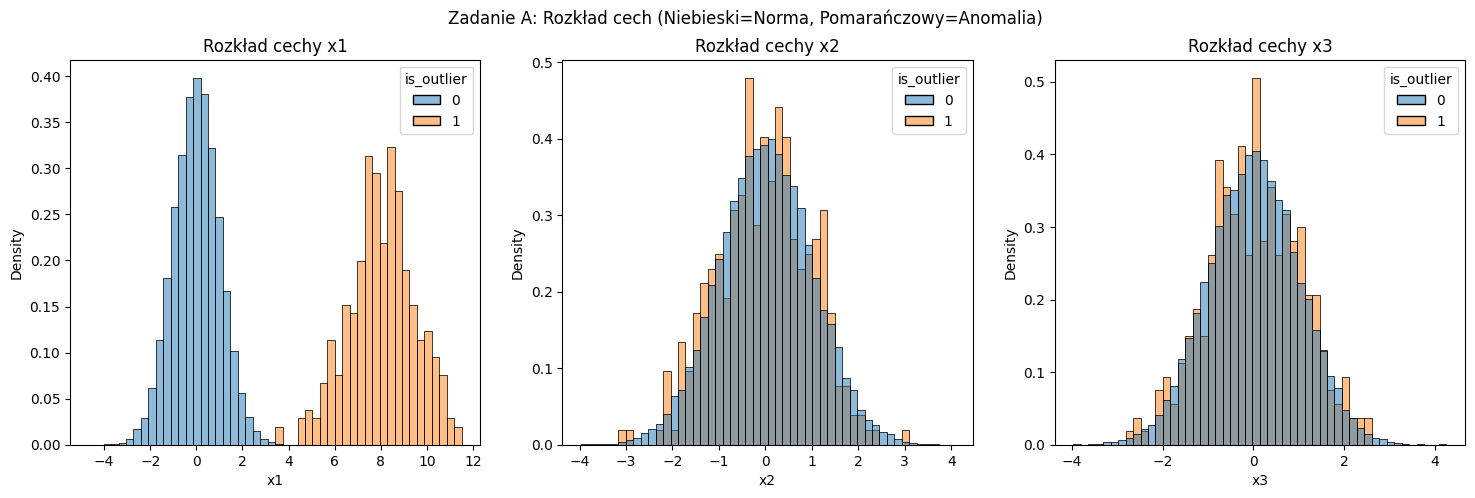

Threshold: 37.73333740234375
+----------+----------+------+
|is_outlier|is_anomaly| count|
+----------+----------+------+
|         0|         0|297000|
|         1|         0|  2999|
|         1|         1|     1|
+----------+----------+------+

TP=1, FP=0, FN=2999
Precision=1.0000, Recall=0.0003


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, IntegerType

# Inicjalizacja Sparka
spark = SparkSession.builder.getOrCreate()

# ==========================================
# 1. Generowanie danych (Zadanie A - ZMODYFIKOWANE)
# ==========================================
# Zmiana 1: Zmniejszenie udziału anomalii do 1% [cite: 332]
n_total = 300_000
frac_outliers = 0.01 
n_out = int(n_total * frac_outliers)
n_norm = n_total - n_out

# Dane normalne ~ N(0,1) - bez zmian
df_norm = (spark.range(n_norm).select(F.col("id").alias("row_id"))
           .withColumn("x1", F.randn(1))
           .withColumn("x2", F.randn(2))
           .withColumn("x3", F.randn(3))
           .withColumn("is_outlier", F.lit(0)))

# Outliery - Zmiana 2: Anomalie subtelne (tylko na x1) [cite: 333-334]
# x1: Zaburzone (N(8, 1.5))
# x2, x3: Normalne (N(0, 1)) - wyglądają jak zwykłe dane!
df_out = (spark.range(n_out).select((F.col("id") + n_norm).alias("row_id"))
          .withColumn("x1", 8.0 + 1.5 * F.randn(11))   # <-- Zaburzenie
          .withColumn("x2", F.randn(12))               # <-- Brak zaburzenia (udaje normę)
          .withColumn("x3", F.randn(13))               # <-- Brak zaburzenia (udaje normę)
          .withColumn("is_outlier", F.lit(1)))

# Połączenie
df = df_norm.unionByName(df_out).orderBy(F.rand(seed=42))

# --- DODATEK: Kod do wygenerowania wykresów do raportu ---
# Pobieramy próbkę do wizualizacji rozkładów (niezbędne do raportu)
viz_sample = df.sample(False, 0.1).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Zadanie A: Rozkład cech (Niebieski=Norma, Pomarańczowy=Anomalia)')

# Rysujemy histogramy dla x1, x2, x3
for i, col in enumerate(['x1', 'x2', 'x3']):
    sns.histplot(data=viz_sample, x=col, hue='is_outlier', bins=50, ax=axes[i], stat='density', common_norm=False)
    axes[i].set_title(f'Rozkład cechy {col}')

plt.show()

# ==========================================
# 2. Kontrakt cech (RĘCZNA STANDARYZACJA)
# ==========================================
# Omijamy pyspark.ml.StandardScaler, który wywala błędy na Serverless.
# Liczymy statystyki globalne:
stats = df.select(
    F.mean("x1").alias("m1"), F.stddev("x1").alias("s1"),
    F.mean("x2").alias("m2"), F.stddev("x2").alias("s2"),
    F.mean("x3").alias("m3"), F.stddev("x3").alias("s3")
).collect()[0]

# Wyciągamy wartości do zmiennych
m1, s1 = stats["m1"], stats["s1"]
m2, s2 = stats["m2"], stats["s2"]
m3, s3 = stats["m3"], stats["s3"]

# Aplikujemy wzór: (x - mean) / std
df_scaled = df.withColumn("x1_s", (F.col("x1") - m1) / s1) \
              .withColumn("x2_s", (F.col("x2") - m2) / s2) \
              .withColumn("x3_s", (F.col("x3") - m3) / s3) \
              .select("row_id", "x1_s", "x2_s", "x3_s", "is_outlier")

# ==========================================
# 3. Autoenkoder: Trening na próbce (Driver)
# ==========================================
train_pd = (df_scaled
            .filter(F.col("is_outlier") == 0)
            .sample(withReplacement=False, fraction=0.10, seed=42)
            .select("x1_s", "x2_s", "x3_s") # Bierzemy 3 kolumny zamiast wektora
            .toPandas())

# Ręczne sklejenie kolumn do macierzy numpy
X_train = train_pd[["x1_s", "x2_s", "x3_s"]].values.astype(np.float32)
input_dim = X_train.shape[1]

# Funkcja budująca model
def build_autoencoder(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    h = tf.keras.layers.Dense(8, activation="relu")(inputs)
    z = tf.keras.layers.Dense(2, activation="relu")(h)
    h2 = tf.keras.layers.Dense(8, activation="relu")(z)
    outputs = tf.keras.layers.Dense(input_dim)(h2)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

# Trening
autoencoder = build_autoencoder(input_dim)
autoencoder.fit(X_train, X_train, epochs=8, batch_size=256, verbose=0)

# Wagi do zmiennej globalnej (mechanizm Closure dla workerów)
GLOBAL_MODEL_WEIGHTS = autoencoder.get_weights()

# ==========================================
# 4. Skoring w Spark (mapInPandas)
# ==========================================
schema = StructType([
    StructField("row_id", LongType(), False),
    StructField("anomaly_score", DoubleType(), False),
    StructField("is_outlier", IntegerType(), False),
])

def score_with_autoencoder(pdf_iter):
    import numpy as np
    import tensorflow as tf
    
    # Odtwarzamy model na workerze
    local_model = build_autoencoder(input_dim=3)
    local_model.set_weights(GLOBAL_MODEL_WEIGHTS)
    
    for pdf in pdf_iter:
        # Zamiast wyciągać z wektora, sklejamy 3 kolumny
        X = pdf[["x1_s", "x2_s", "x3_s"]].values.astype(np.float32)
        
        recon = local_model.predict(X, verbose=0)
        err = np.mean((X - recon) ** 2, axis=1)
        
        yield pd.DataFrame({
            "row_id": pdf["row_id"].values.astype(np.int64),
            "anomaly_score": err.astype(np.float64),
            "is_outlier": pdf["is_outlier"].values.astype(np.int32),
        })

scored = df_scaled.mapInPandas(score_with_autoencoder, schema=schema)

# ==========================================
# 5. Próg i Ewaluacja
# ==========================================
# scored.cache()  <-- Wyłączone dla Serverless

threshold = scored.approxQuantile("anomaly_score", [0.995], 0.01)[0]
print(f"Threshold: {threshold}")

scored = scored.withColumn("is_anomaly", (F.col("anomaly_score") >= F.lit(threshold)).cast("int"))

# Macierz pomyłek
cm = scored.groupBy("is_outlier", "is_anomaly").count().orderBy("is_outlier", "is_anomaly")
cm.show()

# Metryki
tp = scored.filter("is_outlier=1 AND is_anomaly=1").count()
fp = scored.filter("is_outlier=0 AND is_anomaly=1").count()
fn = scored.filter("is_outlier=1 AND is_anomaly=0").count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"Precision={precision:.4f}, Recall={recall:.4f}")